<a href="https://colab.research.google.com/github/lisaong/stackup-workshops/blob/load_image/mask-or-not/mask_or_not.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mask or Not

Trains a Neural Network Classifier to predict whether a face image is wearing a mask or not.

Converts the Neural Network Classifier into a Tensorflow-Lite model for deployment to an embedded device (such as an Arduino).

Instructions on how to run on an ESP32 are here: https://github.com/lisaong/stackup-workshops/tree/master/mask-or-not

In [3]:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
import tensorflow as tf
import pickle

In [4]:
tf.__version__

'2.2.0'

In [13]:
!wget -q https://github.com/lisaong/stackup-workshops/raw/load_image/mask-or-not/data.zip -O data.zip
!unzip -o data.zip

Archive:  data.zip
   creating: data/
   creating: data/mask/
   creating: data/no_mask/
  inflating: data/mask/8.jpg         
  inflating: data/mask/9.jpg         
  inflating: data/mask/11.jpg        
  inflating: data/mask/10.jpg        
  inflating: data/mask/4.jpg         
  inflating: data/mask/5.jpg         
  inflating: data/mask/7.jpg         
  inflating: data/mask/6.jpg         
  inflating: data/mask/2.jpg         
  inflating: data/mask/3.jpg         
  inflating: data/mask/1.jpg         
  inflating: data/no_mask/8.jpg      
  inflating: data/no_mask/9.jpg      
  inflating: data/no_mask/11.jpg     
  inflating: data/no_mask/10.jpg     
  inflating: data/no_mask/4.jpg      
  inflating: data/no_mask/5.jpg      
  inflating: data/no_mask/7.jpg      
  inflating: data/no_mask/6.jpg      
  inflating: data/no_mask/2.jpg      
  inflating: data/no_mask/3.jpg      
  inflating: data/no_mask/1.jpg      


In [14]:
# https://pythonprogramming.net/haar-cascade-face-eye-detection-python-opencv-tutorial/
# https://docs.opencv.org/3.4/db/d28/tutorial_cascade_classifier.html
face_cascade = cv2.CascadeClassifier(f'{cv2.data.haarcascades}haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(f'{cv2.data.haarcascades}haarcascade_eye.xml')

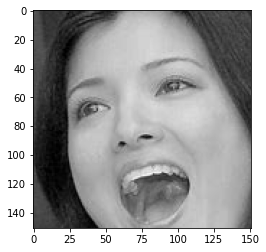

In [15]:
def detect(detector, path):
  img = cv2.imread(path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  faces = detector.detectMultiScale(img)

  for (x,y,w,h) in faces:
    face = img[y:y+h, x:x+w]
    plt.imshow(face, cmap='gray')
    plt.show()
  
detect(face_cascade, './data/no_mask/1.jpg')

In [16]:
detect(face_cascade, './data/mask/1.jpg')

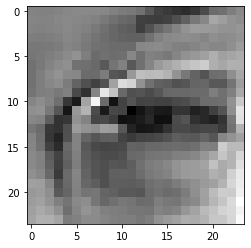

In [17]:
detect(eye_cascade, './data/mask/1.jpg')

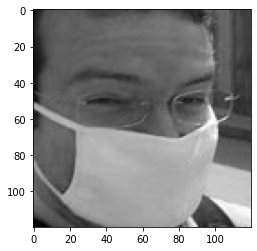

In [18]:
def crop_face(detector, eye_detector, path, output_size=(120, 120)):
  img = cv2.imread(path)
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  height, width, channels = img.shape

  # use the colour version for detection, but the
  # grayscale version for result
  faces = detector.detectMultiScale(img)
  eyes = eye_detector.detectMultiScale(img)

  face = None
  if len(faces) > 0:
    x,y,w,h = faces[0]
    face = gray[y:y+h, x:x+w]
  elif len(eyes) > 0:
    # mask is stumping haar face detection
    # approximate face by detecting the left eye
    x,y,w,h = eyes[0]
    # approximate face dimensions using the
    # left eye as reference
    face = gray[max(0, y-2*h):min(y+4*h, height), 
                max(0, x-3*w):min(x+2*w, width)]
  else:
    # nothing detected, just return original image
    face = gray

  face = cv2.resize(face, output_size)
  plt.imshow(face, cmap='gray')
  plt.show()
  return face

crop_face(face_cascade, eye_cascade, './data/mask/1.jpg');

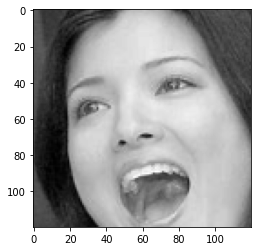

In [19]:
crop_face(face_cascade, eye_cascade, './data/no_mask/1.jpg');

4.jpg


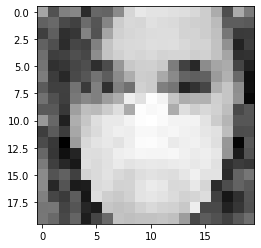

5.jpg


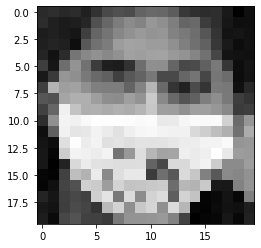

9.jpg


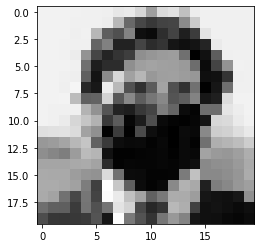

7.jpg


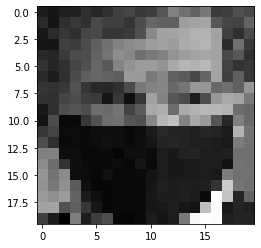

8.jpg


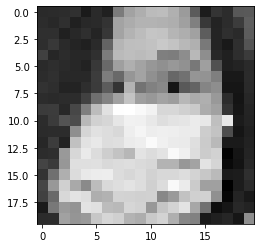

2.jpg


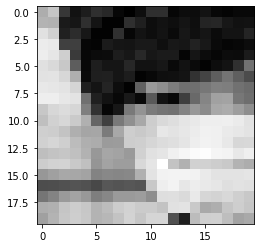

11.jpg


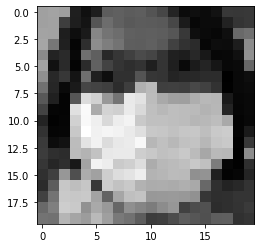

1.jpg


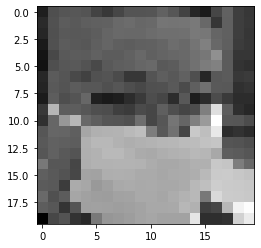

10.jpg


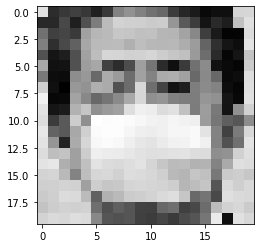

6.jpg


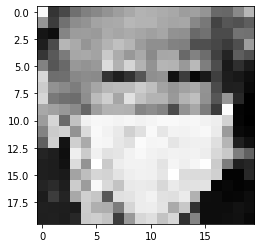

3.jpg


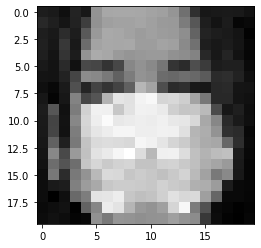

(11, 20, 20)

In [20]:
# Reduce to a small data size so that PCA and the model can fit on ESP32's memory
OUTPUT_SIZE = (20, 20)

def get_image_data(label):
  images = []
  for path in Path(f'./data/{label}').rglob('*.jpg'):
    print(path.name)
    images.append(np.array(crop_face(face_cascade, eye_cascade, 
                                     f'./data/{label}/{path.name}', 
                                     output_size=OUTPUT_SIZE)))
  return np.array(images)

images_mask = get_image_data('mask')
images_mask.shape

4.jpg


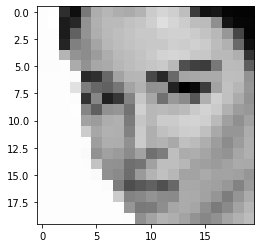

5.jpg


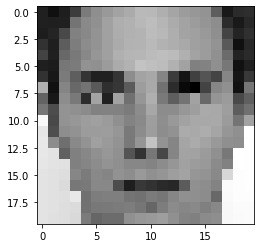

9.jpg


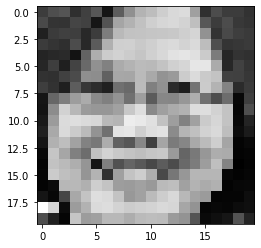

7.jpg


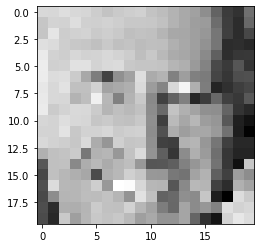

8.jpg


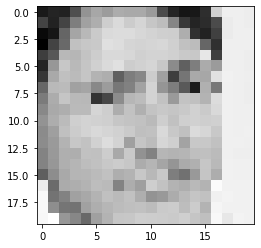

2.jpg


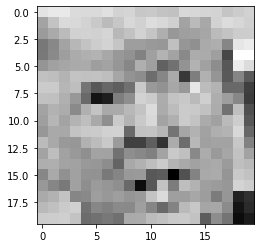

11.jpg


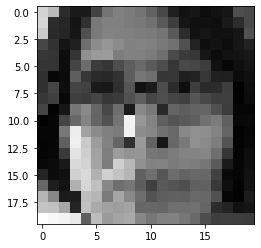

1.jpg


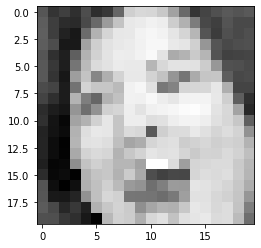

10.jpg


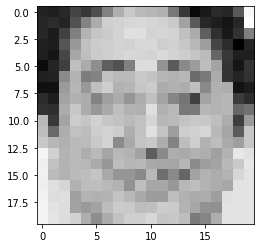

6.jpg


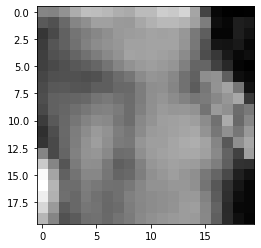

3.jpg


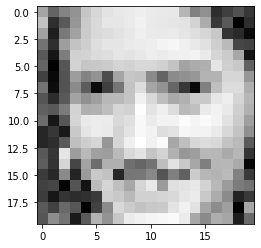

(11, 20, 20)

In [21]:
images_nomask = get_image_data('no_mask')
images_nomask.shape

In [22]:
labels = ['nomask'] * images_nomask.shape[0] + ['mask'] * images_mask.shape[0]
labels

['nomask',
 'nomask',
 'nomask',
 'nomask',
 'nomask',
 'nomask',
 'nomask',
 'nomask',
 'nomask',
 'nomask',
 'nomask',
 'mask',
 'mask',
 'mask',
 'mask',
 'mask',
 'mask',
 'mask',
 'mask',
 'mask',
 'mask',
 'mask']

In [23]:
images = np.vstack([images_nomask, images_mask])
images.shape

(22, 20, 20)

In [24]:
# flatten
X = images.reshape(-1, images.shape[1]*images.shape[2])
X.shape

(22, 400)

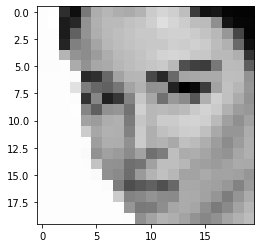

In [25]:
# can we get it back?
plt.imshow(X[0].reshape(images.shape[1], images.shape[2]), cmap='gray')
plt.show()

In [26]:
pca = PCA(n_components=.95)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# tune PCA
pca.fit(X_scaled)

pca.explained_variance_ratio_

array([0.2271698 , 0.18371464, 0.13481895, 0.08549958, 0.05742253,
       0.05089627, 0.03329955, 0.0303337 , 0.02740277, 0.02504762,
       0.02467879, 0.01837503, 0.01568703, 0.01500379, 0.01361543,
       0.0130845 ])

In [27]:
np.arange(1, pca.n_components_+1)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])

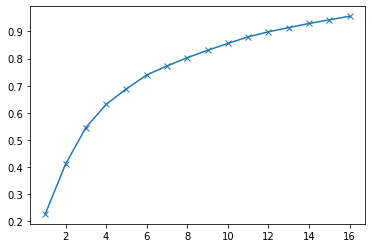

In [28]:
plt.plot(np.arange(1, pca.n_components_+1), pca.explained_variance_ratio_.cumsum(), marker='x')
plt.show()

In [29]:
# choose 7 features
pca = PCA(n_components=7)
Z = pca.fit_transform(X_scaled)

In [30]:
le = LabelEncoder()
y = le.fit_transform(labels)

In [40]:
X_train, X_test, y_train, y_test = train_test_split(Z, y, random_state=42, stratify=y)

In [41]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.6666666666666666

In [42]:
y_pred = lr.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.33      0.50         3
           1       0.60      1.00      0.75         3

    accuracy                           0.67         6
   macro avg       0.80      0.67      0.62         6
weighted avg       0.80      0.67      0.62         6



## Neural Networks

In [53]:
from tensorflow.keras import layers

tf.random.set_seed(42)

mlp = tf.keras.Sequential()
mlp.add(layers.Dense(X_train.shape[1], input_shape=(X_train.shape[1],), activation='relu'))
mlp.add(layers.Dense(X_train.shape[1], activation='relu'))
mlp.add(layers.Dense(1, activation='sigmoid'))
mlp.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 7)                 56        
_________________________________________________________________
dense_10 (Dense)             (None, 7)                 56        
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 8         
Total params: 120
Trainable params: 120
Non-trainable params: 0
_________________________________________________________________


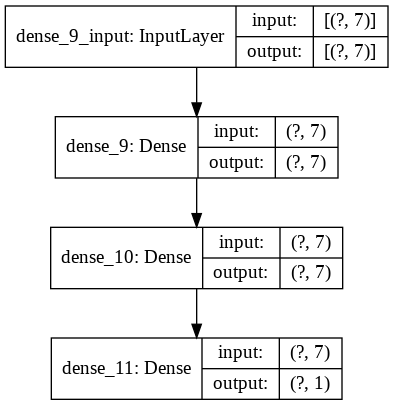

In [54]:
tf.keras.utils.plot_model(mlp, show_shapes=True)

In [55]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=3)
checkpoint = tf.keras.callbacks.ModelCheckpoint('mlp.h5', save_best_only=True)

mlp.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
history = mlp.fit(X_train, y_train, batch_size=5, epochs=80,
                  validation_data=(X_test, y_test),
                  callbacks=[checkpoint, early_stop])

Epoch 1/80
4/4 [==============================] - 0s 40ms/step - loss: 1.8037 - accuracy: 0.5000 - val_loss: 2.2004 - val_accuracy: 0.3333
Epoch 2/80
4/4 [==============================] - 0s 13ms/step - loss: 1.7311 - accuracy: 0.5000 - val_loss: 2.1574 - val_accuracy: 0.3333
Epoch 3/80
4/4 [==============================] - 0s 13ms/step - loss: 1.6859 - accuracy: 0.5000 - val_loss: 2.1107 - val_accuracy: 0.3333
Epoch 4/80
4/4 [==============================] - 0s 15ms/step - loss: 1.6475 - accuracy: 0.5000 - val_loss: 2.0522 - val_accuracy: 0.3333
Epoch 5/80
4/4 [==============================] - 0s 16ms/step - loss: 1.6062 - accuracy: 0.5000 - val_loss: 1.9938 - val_accuracy: 0.3333
Epoch 6/80
4/4 [==============================] - 0s 16ms/step - loss: 1.5649 - accuracy: 0.5000 - val_loss: 1.9316 - val_accuracy: 0.3333
Epoch 7/80
4/4 [==============================] - 0s 15ms/step - loss: 1.5188 - accuracy: 0.5000 - val_loss: 1.8762 - val_accuracy: 0.3333
Epoch 8/80
4/4 [===========

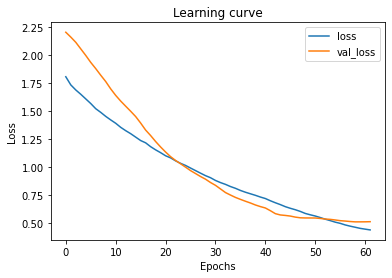

In [56]:
# learning curve
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Learning curve')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [57]:
y_pred = lr.predict(X_test)
baseline_metrics = classification_report(y_test, y_pred)
print(baseline_metrics)

              precision    recall  f1-score   support

           0       1.00      0.33      0.50         3
           1       0.60      1.00      0.75         3

    accuracy                           0.67         6
   macro avg       0.80      0.67      0.62         6
weighted avg       0.80      0.67      0.62         6



In [58]:
y_pred_mlp = mlp.predict(X_test) >= 0.5
mlp_metrics = classification_report(y_test, y_pred_mlp)
print(mlp_metrics)

              precision    recall  f1-score   support

           0       0.67      0.67      0.67         3
           1       0.67      0.67      0.67         3

    accuracy                           0.67         6
   macro avg       0.67      0.67      0.67         6
weighted avg       0.67      0.67      0.67         6



## Convolutional Neural Networks

4.jpg


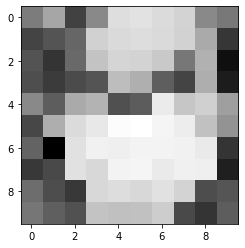

5.jpg


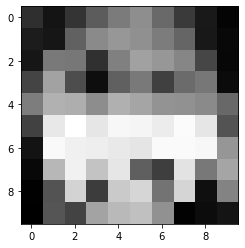

9.jpg


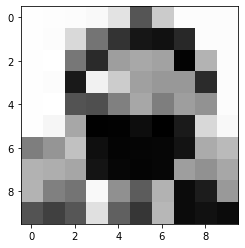

7.jpg


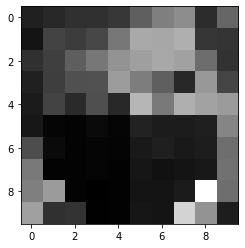

8.jpg


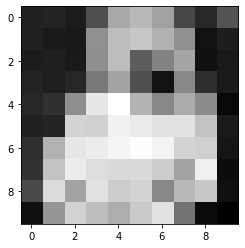

2.jpg


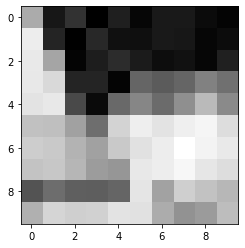

11.jpg


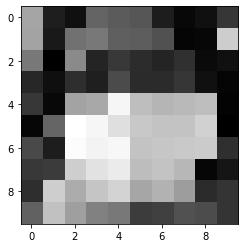

1.jpg


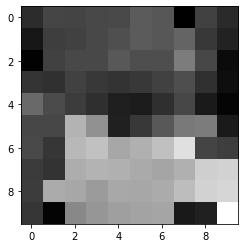

10.jpg


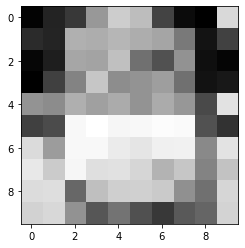

6.jpg


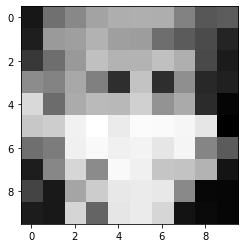

3.jpg


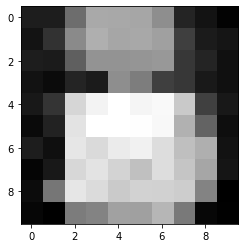

4.jpg


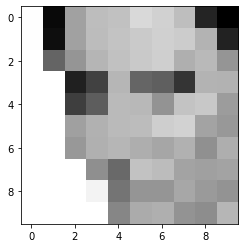

5.jpg


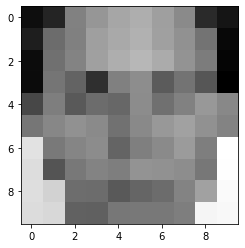

9.jpg


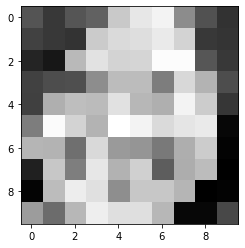

7.jpg


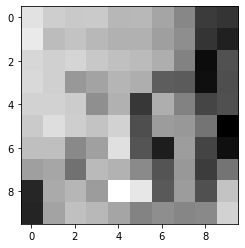

8.jpg


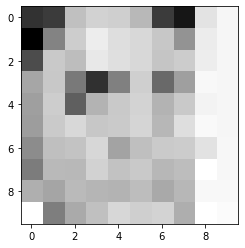

2.jpg


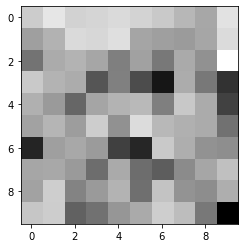

11.jpg


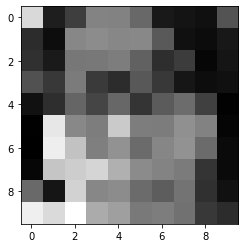

1.jpg


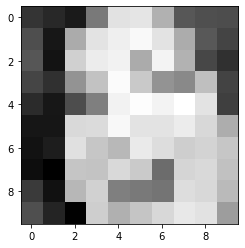

10.jpg


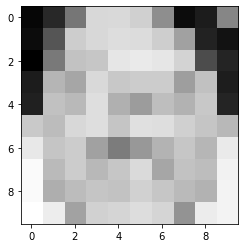

6.jpg


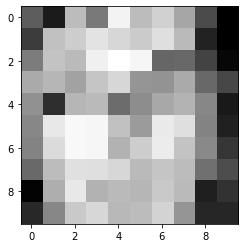

3.jpg


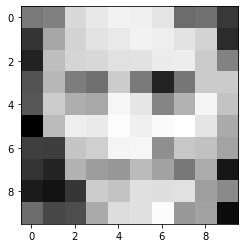

In [78]:
OUTPUT_SIZE = (10, 10)
images_mask = get_image_data('mask')
images_nomask = get_image_data('no_mask')
X_cnn = np.vstack([images_nomask, images_mask])

In [79]:
X_cnn[0]

array([[252,  15, 162, 189, 193, 216, 208, 190,  41,   6],
       [252,  20, 162, 188, 195, 201, 207, 203, 180,  39],
       [253, 103, 150, 181, 193, 200, 206, 175, 185, 150],
       [253, 253,  37,  69, 182, 104,  98,  57, 180, 178],
       [253, 253,  66,  96, 186, 184, 149, 195, 199, 157],
       [253, 253, 161, 177, 186, 188, 205, 209, 164, 153],
       [253, 253, 153, 176, 182, 174, 167, 177, 145, 174],
       [253, 253, 253, 144, 108, 194, 188, 165, 161, 164],
       [253, 253, 253, 241, 118, 150, 150, 168, 155, 149],
       [253, 253, 253, 253, 136, 171, 175, 148, 143, 182]], dtype=uint8)

In [80]:
# add channel dimension
X_cnn = np.expand_dims(X_cnn, axis=3)
X_cnn.shape

(22, 10, 10, 1)

In [81]:
# scale
X_cnn_scaled = (X_cnn - 127.0)/128

# split
X_train, X_test, y_train, y_test = train_test_split(X_cnn_scaled, y, 
                                                    random_state=42, stratify=y)
X_train.shape

(16, 10, 10, 1)

In [92]:
# https://towardsdatascience.com/a-basic-introduction-to-separable-convolutions-b99ec3102728
cnn = tf.keras.Sequential()
cnn.add(layers.SeparableConv2D(5, 3, 
        input_shape=(X_train.shape[1],X_train.shape[2], X_train.shape[3]), activation='relu'))
#cnn.add(layers.MaxPool2D())
cnn.add(layers.Flatten())
cnn.add(layers.Dense(1, activation='sigmoid'))
cnn.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv2d_4 (Separabl (None, 8, 8, 5)           19        
_________________________________________________________________
flatten_4 (Flatten)          (None, 320)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 321       
Total params: 340
Trainable params: 340
Non-trainable params: 0
_________________________________________________________________


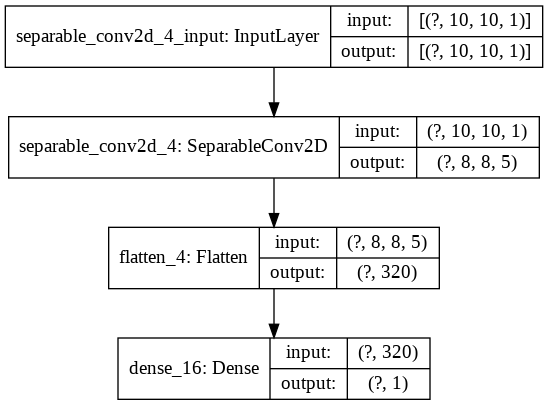

In [93]:
tf.keras.utils.plot_model(cnn, show_shapes=True)

In [94]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=3)
checkpoint = tf.keras.callbacks.ModelCheckpoint('cnn.h5', save_best_only=True)

cnn.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
history = cnn.fit(X_train, y_train, batch_size=5, epochs=60,
                  validation_data=(X_test, y_test),
                  callbacks=[checkpoint, early_stop])

Epoch 1/60
4/4 [==============================] - 0s 36ms/step - loss: 0.7202 - accuracy: 0.5625 - val_loss: 0.6666 - val_accuracy: 0.5000
Epoch 2/60
4/4 [==============================] - 0s 20ms/step - loss: 0.6992 - accuracy: 0.6250 - val_loss: 0.6647 - val_accuracy: 0.5000
Epoch 3/60
4/4 [==============================] - 0s 15ms/step - loss: 0.6775 - accuracy: 0.7500 - val_loss: 0.6628 - val_accuracy: 0.6667
Epoch 4/60
4/4 [==============================] - 0s 15ms/step - loss: 0.6622 - accuracy: 0.7500 - val_loss: 0.6579 - val_accuracy: 0.6667
Epoch 5/60
4/4 [==============================] - 0s 16ms/step - loss: 0.6479 - accuracy: 0.8750 - val_loss: 0.6492 - val_accuracy: 0.6667
Epoch 6/60
4/4 [==============================] - 0s 17ms/step - loss: 0.6355 - accuracy: 0.9375 - val_loss: 0.6396 - val_accuracy: 0.8333
Epoch 7/60
4/4 [==============================] - 0s 14ms/step - loss: 0.6252 - accuracy: 0.9375 - val_loss: 0.6322 - val_accuracy: 0.8333
Epoch 8/60
4/4 [===========

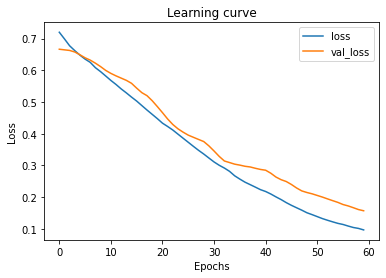

In [95]:
# learning curve
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Learning curve')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [96]:
y_pred_cnn = cnn.predict(X_test) >= 0.5
cnn_metrics = classification_report(y_test, y_pred_cnn)
print(cnn_metrics)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         3

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6



In [97]:
print(mlp_metrics)

              precision    recall  f1-score   support

           0       0.67      0.67      0.67         3
           1       0.67      0.67      0.67         3

    accuracy                           0.67         6
   macro avg       0.67      0.67      0.67         6
weighted avg       0.67      0.67      0.67         6



In [98]:
print(baseline_metrics)

              precision    recall  f1-score   support

           0       1.00      0.33      0.50         3
           1       0.60      1.00      0.75         3

    accuracy                           0.67         6
   macro avg       0.80      0.67      0.62         6
weighted avg       0.80      0.67      0.62         6



## Quantization to TFLite

https://www.tensorflow.org/lite/microcontrollers/build_convert

In [99]:
converter = tf.lite.TFLiteConverter.from_keras_model(cnn)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()
open('cnn.tflite', 'wb').write(tflite_model)

3232

In [100]:
# Test model loading
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path='cnn.tflite')
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
input_shape = input_details[0]['shape']

y_pred_tflite = []

# Test model on input data.
# Loop through each row of test_data and perform inference
for i in range(X_test.shape[0]):

  # add batch dimension
  input_data = np.expand_dims(X_test[i], axis=0).astype('float32')
  interpreter.set_tensor(input_details[0]['index'], input_data)
  interpreter.invoke()

  # The function `get_tensor()` returns a copy of the tensor data.
  # Use `tensor()` in order to get a pointer to the tensor.
  output_data = interpreter.get_tensor(output_details[0]['index'])
  y_pred_tflite.append(output_data[0][0])

print(classification_report(y_test, np.array(y_pred_tflite) >= 0.5))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         3

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6



In [101]:
!pip install tinymlgen

  Created wheel for tinymlgen: filename=tinymlgen-0.2-cp36-none-any.whl size=2245 sha256=9ff8e60312f26589adc3866a52710246a9623cff8144344c8b55763dd3e8262a
  Stored in directory: /root/.cache/pip/wheels/a1/84/4d/3c1a67c7b9483e296ff1b2f4a13e2f800ca2a6093b741450d2
  Created wheel for hexdump: filename=hexdump-3.3-cp36-none-any.whl size=8914 sha256=721cc89bab382ee4c7a8482871838d79444d57d73e2826823d4a1d9aa973d3ad
  Stored in directory: /root/.cache/pip/wheels/d5/d1/f2/c8183b5863b3df595c2eeafd8e015a43dae13d403a959467c6
Successfully built tinymlgen hexdump


In [102]:
# https://github.com/eloquentarduino/tinymlgen
import tinymlgen

c_code = tinymlgen.port(cnn)

# input should be flattened like this:
#   image_width * image_height * channels
# Ref: https://github.com/tensorflow/tensorflow/blob/59c06b9016700dbf1ab0cefc062d247345cdd0f0/tensorflow/lite/micro/examples/person_detection/image_provider.cc
input_shape = OUTPUT_SIZE[0]*OUTPUT_SIZE[1]*1

with open('cnn.h', 'w') as f:
  f.write(c_code)

  # add defines that will be used by application code
  f.write(f'\n\n#define NUMBER_OF_INPUTS {input_shape}\n')
  f.write(f'#define NUMBER_OF_OUTPUTS {cnn.get_output_shape_at(0)[1]}\n')

In [103]:
with open('cnn.h', 'r') as f:
  print(f.read())


#ifdef __has_attribute
#define HAVE_ATTRIBUTE(x) __has_attribute(x)
#else
#define HAVE_ATTRIBUTE(x) 0
#endif
#if HAVE_ATTRIBUTE(aligned) || (defined(__GNUC__) && !defined(__clang__))
#define DATA_ALIGN_ATTRIBUTE __attribute__((aligned(4)))
#else
#define DATA_ALIGN_ATTRIBUTE
#endif

const unsigned char model_data[] DATA_ALIGN_ATTRIBUTE = {0x08, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0xba, 0xf9, 0xff, 0xff, 0x03, 0x00, 0x00, 0x00, 0x30, 0x0c, 0x00, 0x00, 0x30, 0x06, 0x00, 0x00, 0x18, 0x06, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0x0e, 0x00, 0x00, 0x00, 0x08, 0x06, 0x00, 0x00, 0x00, 0x06, 0x00, 0x00, 0xec, 0x05, 0x00, 0x00, 0xcc, 0x05, 0x00, 0x00, 0xbc, 0x00, 0x00, 0x00, 0xa8, 0x00, 0x00, 0x00, 0x74, 0x00, 0x00, 0x00, 0x50, 0x00, 0x00, 0x00, 0x2c, 0x00, 0x00, 0x00, 0x24, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00, 0x14, 0x00, 0x00, 0x00, 0x0c, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0x58, 0xf4, 0xff, 0xff, 0x5c, 0xf4, 0xff, 0xff, 0x60, 0xf4, 0xff, 0xff, 0x64, 0xf4, 0xff, 0xff, 0x68, 0xf4,

## Port PCA to Arduino

https://eloquentarduino.github.io/2020/06/arduino-dimensionality-reduction-pca-for-machine-learning-projects/

In [104]:
!pip install micromlgen

  Created wheel for micromlgen: filename=micromlgen-1.1.2-cp36-none-any.whl size=11256 sha256=61d06053ca6a23a2189136da1bc5e692b0bfe9945b394f3779dd2669f0a9eb4e
  Stored in directory: /root/.cache/pip/wheels/13/4d/83/d20a7754ef19d92a17f1da204b30ca890b58a363c51139d1a5
Successfully built micromlgen


In [105]:
import micromlgen

c_code = micromlgen.port(pca)
with open('pca.h', 'w') as f:
  f.write(c_code)

  # add defines that will be used by application code
  f.write(f'\n\n#define PCA_INPUT_SIZE {OUTPUT_SIZE[0]*OUTPUT_SIZE[1]}\n')

In [106]:
with open('pca.h', 'r') as f:
  print(f.read())

#pragma once
namespace Eloquent {
    namespace ML {
        namespace Port {
            class PCA {
                public:
                    /**
                    * Apply dimensionality reduction
                    * @warn Will override the source vector if no dest provided!
                    */
                    void transform(float *x, float *dest = NULL) {
                        static float u[7] = { 0 };
                        u[0] = dot(x,   0.005151520024  , 0.033004599005  , 0.025986341599  , 0.027226431141  , 0.037491618807  , 0.027522767921  , 0.027167184414  , 0.005439862485  , -0.013899034611  , -0.026761922198  , -0.041112477892  , -0.017659530944  , -0.000675468896  , 0.00392565489  , 0.023167600066  , 0.033635331905  , 0.022158793297  , 0.029876646564  , 0.009193397975  , 0.003526361068  , 0.025349187635  , 0.022912417922  , 0.035718517345  , 0.036896678604  , 0.02536266807  , 0.024229695609  , 0.001570185279  , -0.038311747114  , -0.065186565851  , -0.06457

In [107]:
# Continuous integration is enabled on this notebook
# store artifacts for CI testing

ci_artifacts = {
    'inputs' : {
        'X' : X,
        'X_cnn' : X_cnn_scaled
    },

    'target' : {
        'y' : y,
        'encoder' : le
    },

    'preprocessors' : {
      'scaler' : scaler,
      'pca' : pca
    },

    'baseline' : {
        'input' : 'X',
        'model' : lr,
        'preprocessors' : [
          'scaler',
          'pca'
        ],
    },

    # model1 spec
    'mlp' : {
        'input' : 'X',
        'scaler' : scaler,
        'preprocessors' : [
          'scaler',
          'pca'                 
        ],
        'h5' : 'mlp.h5'
    },

    # model2 spec
    'cnn' : {
        'input' : 'X_cnn',
        'preprocessors' : [
        ],
        'h5' : 'cnn.h5',
        'tflite' : 'cnn.tflite',
        'h' : 'cnn.h' 
    }
}

pickle.dump(ci_artifacts, open('ci_artifacts.pkl', 'wb'))

In [108]:
# tests for continuous integration of the model
import unittest
import numpy as np
import pickle
import tensorflow as tf
from sklearn.metrics import classification_report

class ModelTestcase(unittest.TestCase):
    def setUp(self):
        """Called before every test case."""
        with open('ci_artifacts.pkl', 'rb') as f:
            ci_artifacts = pickle.load(f)
            self.inputs = ci_artifacts['inputs']
            self.target = ci_artifacts['target']
            self.preprocessors = ci_artifacts['preprocessors']
            self.baseline = ci_artifacts['baseline']
            self.mlp = ci_artifacts['mlp']
            self.cnn = ci_artifacts['cnn']

    def tearDown(self):
        """Called after every test case."""
        pass

    def _testSkLearnModel(self, model_spec):
        model = model_spec['model']
        X = self.inputs[model_spec['input']]
        for p in model_spec['preprocessors']:
          X = self.preprocessors[p].transform(X)
        y_pred = model.predict(X)
        print(model)
        print(classification_report(self.target['y'], y_pred))

    def _testTFModel(self, model_spec):
        model = tf.keras.models.load_model(model_spec['h5'])
        X = self.inputs[model_spec['input']]
        for p in model_spec['preprocessors']:
          X = self.preprocessors[p].transform(X)
        y_pred = model.predict(X) >= 0.5
        print(model.summary())
        print(classification_report(self.target['y'], y_pred))

    def testBaseline(self):
        print('Testing Baseline')
        self._testSkLearnModel(self.baseline)

    def testMLP(self):
        print('Testing MLP')
        self._testTFModel(self.mlp)

    def testCNN(self):
        print('Testing CNN')
        self._testTFModel(self.cnn)

    def testCNNTFLite(self):
        print('Testing TFLite Model')
        self._testTFLiteModel(self.cnn)

    def _testTFLiteModel(self, model_spec):
        y_pred = []

        # Load TFLite model and allocate tensors.
        interpreter = tf.lite.Interpreter(model_path=model_spec['tflite'])
        interpreter.allocate_tensors()

        # Get input and output tensors.
        input_details = interpreter.get_input_details()
        output_details = interpreter.get_output_details()
        input_shape = input_details[0]['shape']

        # Test model on input data.
        # Loop through each row of test_data and perform inference
        model_input = self.inputs[model_spec['input']]
        for i in range(model_input.shape[0]):

            # add batch dimension
            input_data = np.expand_dims(model_input[i], axis=0).astype('float32')
            interpreter.set_tensor(input_details[0]['index'], input_data)
            interpreter.invoke()

            # The function `get_tensor()` returns a copy of the tensor data.
            # Use `tensor()` in order to get a pointer to the tensor.
            output_data = interpreter.get_tensor(output_details[0]['index'])
            y_pred.append(output_data[0][0])

        print(classification_report(self.target['y'], np.array(y_pred) >= 0.5))        

if __name__ == '__main__':
    # run all tests, the argument is for running on Jupyter,
    # but needs to be removed for the CI test as it will hide failures.
    unittest.main(argv=['first-arg-is-ignored'], exit=False)

...

Testing Baseline
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
              precision    recall  f1-score   support

           0       1.00      0.82      0.90        11
           1       0.85      1.00      0.92        11

    accuracy                           0.91        22
   macro avg       0.92      0.91      0.91        22
weighted avg       0.92      0.91      0.91        22

Testing CNN
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv2d_4 (Separabl (None, 8, 8, 5)           19        
_________________________________________________________________
flatten_4 (Flatten)          (No

.

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 7)                 56        
_________________________________________________________________
dense_10 (Dense)             (None, 7)                 56        
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 8         
Total params: 120
Trainable params: 120
Non-trainable params: 0
_________________________________________________________________
None
              precision    recall  f1-score   support

           0       0.80      0.73      0.76        11
           1       0.75      0.82      0.78        11

    accuracy                           0.77        22
   macro avg       0.78      0.77      0.77        22
weighted avg       0.78      0.77      0.77        22




----------------------------------------------------------------------
Ran 4 tests in 0.279s

OK
